Cluster students by skill level.

Inputs:

- gradebook data (formative assessments)
- assignment weight (100 - median grade)

Outputs:

- plot students in latent space
- kmeans clusters

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture
import string
import itertools

%matplotlib inline

,Student ID,Gender,Age,Race/Ethnicity,SPED Status,Quiz 1,Quiz 2,Quiz 3,Final Grade
0,18503,M,16,American Indian or Alaska Native,False,11,97,5,37.666667
1,90106,M,16,Native Hawaiian or Other Pacific Islander,False,12,95,25,44.000000
2,65296,F,16,White,False,10,89,8,35.666667
3,11274,F,15,Hispanic/Latino,False,90,19,80,63.000000
4,36210,M,17,American Indian or Alaska Native,True,91,9,75,58.333333


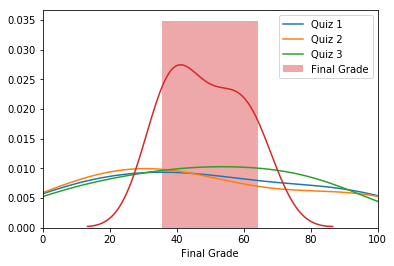

In [437]:
# 1. Simulate Data

def simulate_grades(mu, sigma, n_students):
    grades = []
    for i in range(n_students):
        g = -1
        while g<0 or g>100:
            g = np.random.normal(mu, sigma)
        grades.append(g)
    return grades


def simulate_gradebook(n_students=20):
    gb =  pd.DataFrame({'Student ID': np.random.choice(100000, n_students, replace=False),
                        'Gender': np.random.choice(['M', 'F'], n_students),
                        'Age': np.random.choice([15, 16, 16, 17], n_students),
                        'Race/Ethnicity': np.random.choice(['Hispanic/Latino', 'American Indian or Alaska Native',
                                                            'Asian', 'Black or African American',
                                                            'Native Hawaiian or Other Pacific Islander', 'White',
                                                            'Two or more races'], n_students),
                        'SPED Status': np.random.choice([False,True], n_students, p=[0.8, 0.2]),
                        'Quiz 1': [11,12,10,90,91,92,50,55,41,38], #simulate_grades(mu, sigma, n_students)
                        'Quiz 2': [97,95,89,19,9,11,50,45,40,30],
                        'Quiz 3': [5,25,8,80,75,90,50,65,43,40]})
    gb['Final Grade'] = gb[['Quiz 1', 'Quiz 2', 'Quiz 3']].mean(axis='columns')
    return gb

gb = simulate_gradebook(10)
display(gb.head())

for col in ['Quiz 1', 'Quiz 2', 'Quiz 3', 'Final Grade']:
    sns.distplot(gb[col], hist=True if col=='Final Grade' else False, label=col)
plt.legend()
plt.xlim([0,100])
plt.show()

In [438]:
def optimalK(data, nrefs=3, maxClusters=20):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)

In [433]:
# optimize clusters or take a set number of groups
def cluster(data=gb[['Quiz 1', 'Quiz 2', 'Quiz 3']], n_groups=None):
    start = 1 if n_groups==None else n_groups-1
    n_iterations = 20 if n_groups==None else n_groups
    
    for i in range(start, n_iterations):
        n_groups = i+1
        
        # K-Means
        kmeans = KMeans(n_groups).fit(data)
        gb['kmeans'] = [string.ascii_uppercase[i] for i in kmeans.labels_]

        # Gaussian Mixture Model
        gm = GaussianMixture(n_groups, n_init=100).fit(data)
        data['gaussmix'] = gm.predict(data)
        data['gaussmix'] = data['gaussmix'].map(lambda i: string.ascii_uppercase[i])

        # comparison of mappings
        #display(gb.groupby(['kmeans', 'gaussmix']).size())

Optimal k is 4


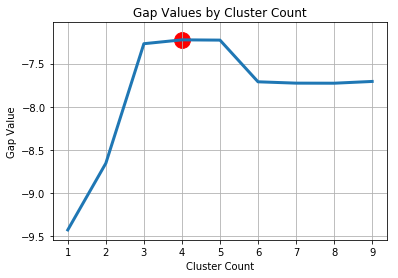

In [484]:
# 2. Cluster

data = gb[['Quiz 1', 'Quiz 2', 'Quiz 3']]

n_clusters, gapdf = optimalK(data, nrefs=10, maxClusters=gb.shape[0])

print('Optimal k is', n_clusters)
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == n_clusters].clusterCount,
            gapdf[gapdf.clusterCount == n_clusters].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

kmeans = KMeans(n_clusters).fit(data)
gb['kmeans'] = [string.ascii_uppercase[i] for i in kmeans.labels_]

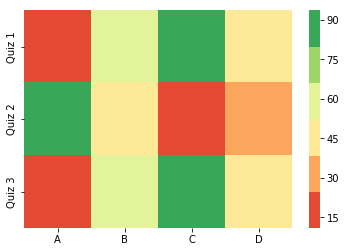

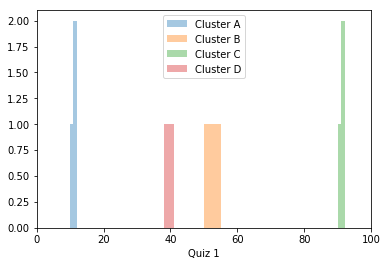

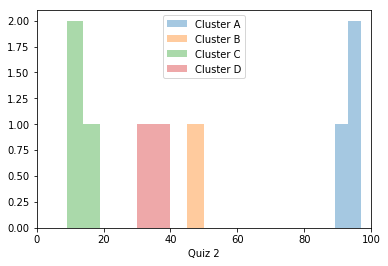

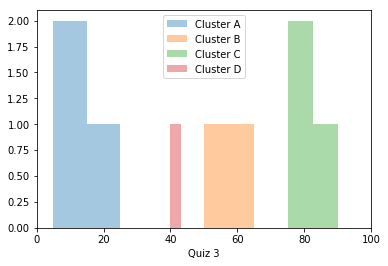

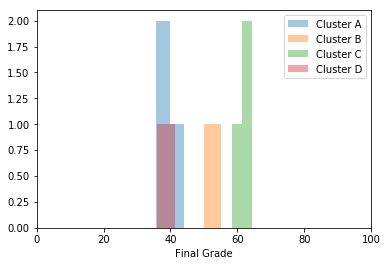

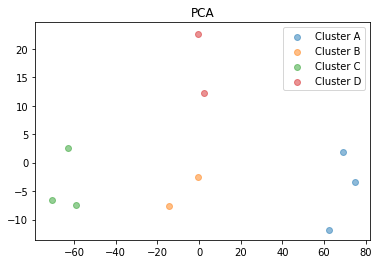

explained variance ratio: 99.0% explained [0.9553566  0.03505838]


In [485]:
# 3. Visualize Clusters

cluster_method = 'kmeans'

# K-Means
sns.heatmap(kmeans.cluster_centers_.T, cmap=sns.color_palette('RdYlGn_r')[::-1])
plt.xticks(np.arange(n_clusters)+0.5, string.ascii_uppercase[:n_clusters])
plt.yticks(np.arange(3)+0.5, ['Quiz 1', 'Quiz 2', 'Quiz 3'], verticalalignment='center')
plt.show()


# Gaussiam Mixture Model
for col in ['Quiz 1', 'Quiz 2', 'Quiz 3', 'Final Grade']:
    for i in string.ascii_uppercase[:n_clusters]:
        sns.distplot(gb.loc[gb[cluster_method]==i, col], kde=False, label=f'Cluster {i}')
    plt.legend()
    plt.xlim([0,100])
    plt.show()
    

# PCA
X = gb[['Quiz 1', 'Quiz 2', 'Quiz 3']]
y = gb[cluster_method]
cluster_labels = gb[cluster_method].drop_duplicates().sort_values().values
target_names = cluster_labels

pca = PCA(n_components=2)
X_reduced = pca.fit(X).transform(X)

for i, target_name in zip(cluster_labels, target_names):
    plt.scatter(X_reduced[y==i, 0], X_reduced[y==i, 1], label=f'Cluster {target_name}', alpha=0.5)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()

# Percentage of variance explained for each components
print('explained variance ratio: {}% explained {}'
      .format(round(sum(pca.explained_variance_ratio_), 3)*100, pca.explained_variance_ratio_))

Group A: 18503, 90106, 65296
Group B: 50146, 94006
Group C: 11274, 36210, 35559
Group D: 52440, 85755


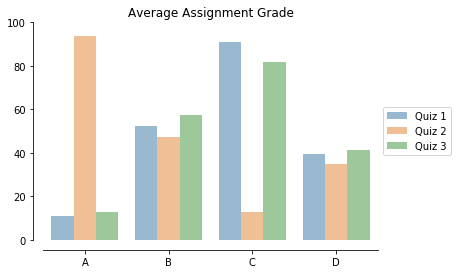

Recommendations:
Group A should focus on Quiz 1
Group B should focus on Quiz 2
Group C should focus on Quiz 2
Group D should focus on Quiz 2


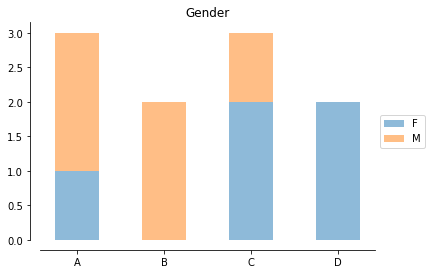

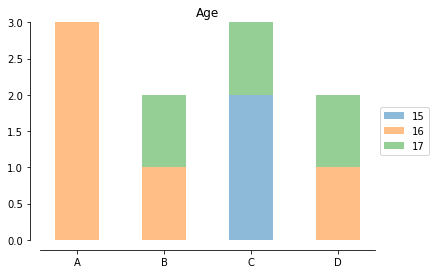

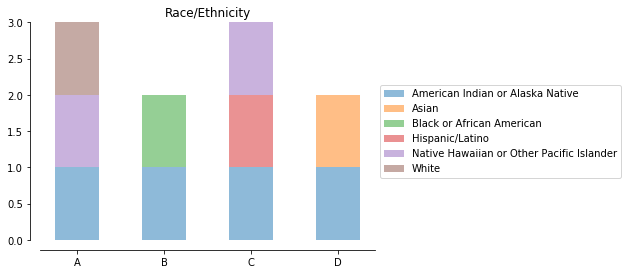

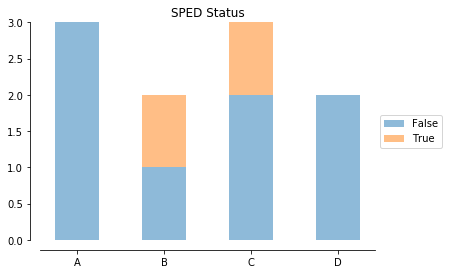

In [486]:
# 4. Describe Clusters and Offer Recommendations

# which students are in which group?
for label in string.ascii_uppercase[:n_clusters]:
    print(f"Group {label}: {', '.join(gb.loc[gb[cluster_method]==label, 'Student ID'].astype(str).values)}")

# average scores by cluster
palette = sns.color_palette()
temp = gb.groupby(cluster_method)[['Quiz 1', 'Quiz 2', 'Quiz 3']].mean()
recommendations = pd.DataFrame(temp.apply(lambda x: temp.columns[x.values.argmin()], axis='columns'))
temp = temp.stack().reset_index().rename({'level_1':'quiz', 0:'grade', cluster_method:'cluster'}, axis='columns')
b = sns.barplot('cluster', 'grade', 'quiz', data=temp, alpha=0.5, palette=palette)
sns.despine(offset=10, trim=False)
b.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,100])
plt.xlabel('')
plt.ylabel('')
plt.title('Average Assignment Grade')
plt.show()

# which assignment does each group need to focus on?
print('Recommendations:')
for label in recommendations.index:
    print(f'Group {label} should focus on {recommendations.loc[label].values[0]}')

    
# similarities and differences on other characteristics (gender, age, race, SPED)
for field in ['Gender', 'Age', 'Race/Ethnicity', 'SPED Status']:
    temp = gb.groupby([cluster_method, field]).size()
    temp = temp.reindex(pd.MultiIndex.from_product(temp.index.levels),
                        fill_value=0.0)\
                .reset_index()\
                .rename({'level_0':'cluster', 'level_1':field, 0:'count'}, axis='columns')
    temp['count'] = temp['count'].astype(int)
    values = temp[field].drop_duplicates()
    palette = itertools.cycle(sns.color_palette())
    bottom = np.zeros(n_clusters)
    plots = []
    for i, value in enumerate(values):
        g = plt.bar(temp.loc[temp[field]==value, 'cluster'],
                temp.loc[temp[field]==value, 'count'],
                width=0.5, alpha=0.5, color=next(palette),
                bottom=bottom)
        plots.append(g)
        bottom = np.add(bottom, temp.loc[temp[field]==value, 'count'])
    sns.despine(offset=10, trim=False)
    plt.legend(plots, values, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(field)
    plt.show()